# Lorenz 63 supermodel (a revisit of Schevenhoven and Selten, 2017)


## 1. Introduction
This is an Python implementation  of a supermodel of the Lorenz 63 model using the Cross pollination training (CPT) algorithm from Schevenhoven and Selten (2017). Thus, I try to reproduce their algorithm using python.

Suppose we have a model that predict a variale $X$. Ensemble methods use different variations of the model and/or different initial values to predict $X$, then apply a post-processing ensemble method. A `supermodel` also uses, for example $N$ variations of the model, at each time step will produce $N$ predictions: $X_1 ... X_N$, the idea is finding N weight factors $w_1,...,W_N$, so a new prediction is made at each time step:
$X_s = \sum{w_i X_i}$

This new prediction is use to predict the next time step for **all** model members.
The combination of the optimal set of weight factors leads to some kind of "perfect model", thus it does not deal with the initial value problem. However, this may be a good method in climate models where the initial values are not critical important.


<img src="./images/supermodel.png" width=400>
Fig1. An adaptation from Francine et al 2017.

## 2. Algorithm

Schevenhoven and Selten (2017) described the CPT in words, **but did not show explicitly** how the weights updated in the interation steps (when a supermodel from the previous time step is envolved).

Suppose we $N$ model members, the first weight approximation choice is $w_i=1/N$ for $i=1,...,N$.
The interative process to find the optimal weights as follows (pseudocode):

* Initialize $w_i=1/N$ 
* Loop until max_iterations or optimal weights are found:
    * Integrate N models for each time step in the trainig window
        *  Calculate $X_s= \sum(w_i*X_i) $, where $X_i$ is a prediction of one model.
        *  Compare $X_i$ and $X_s$ ($N+1$ values) with the observation $X_o$, 
        *  The winner is used to as the input for all $N$ models to integrate to the next time step  
        
    * Compute the probabilities of winning prediction for each models (including the supermodel $_S$): $p_1,...,p_N, p_S$  (hence $(\sum{p_i}) + p_S = 1$)
    * Update the weights of the supermodel by: 
    
    $w_i = p_sw_i + (1-p_s)\frac{p_i}{\sum\limits_{k=1}^N{p_k}}$, where $i=1,...,N$,
    
    this will ensure $\sum\limits_{i=1}^N{w_i}=1$
    
    We can also introduce a learning rate ($0<\epsilon\le1$), for a gradual convergence:

    $w_i = (1-\epsilon+p_s\epsilon)w_i + \epsilon(1-p_s)\frac{p_i}{\sum\limits_{k=1}^N{p_k}}$
    
    * The *perfect* optimal weights are found if $p_s=1$ and $p_i=0$ for all $i=1,...,N$
    
    


## 3. The Lorenz 63 model 
The Lorenz 63 model is a simple Lagrangian model of three state variables $(x,y,z)$ and three parameters ($\sigma, \rho, \beta$):

$
\begin{array}{l}
\dot x = \sigma (y - x)\\
\dot y = x(\rho  - z) - y\\
\dot z = xy - \beta z
\end{array}
$

Assume the true model has $(\sigma = 10, \rho = 28,  \beta = 8/3)$ and we have 2 imperfect models with  $(\sigma = 12.25, \rho = 19,  \beta = 3.3)$ and  $(\sigma = 7.5, \rho = 35,  \beta = 1.9)$

We want to find $3$ sets of weights, $w_{xi}$, $w_{yi}$, $w_{zi}$, where i=1, 2


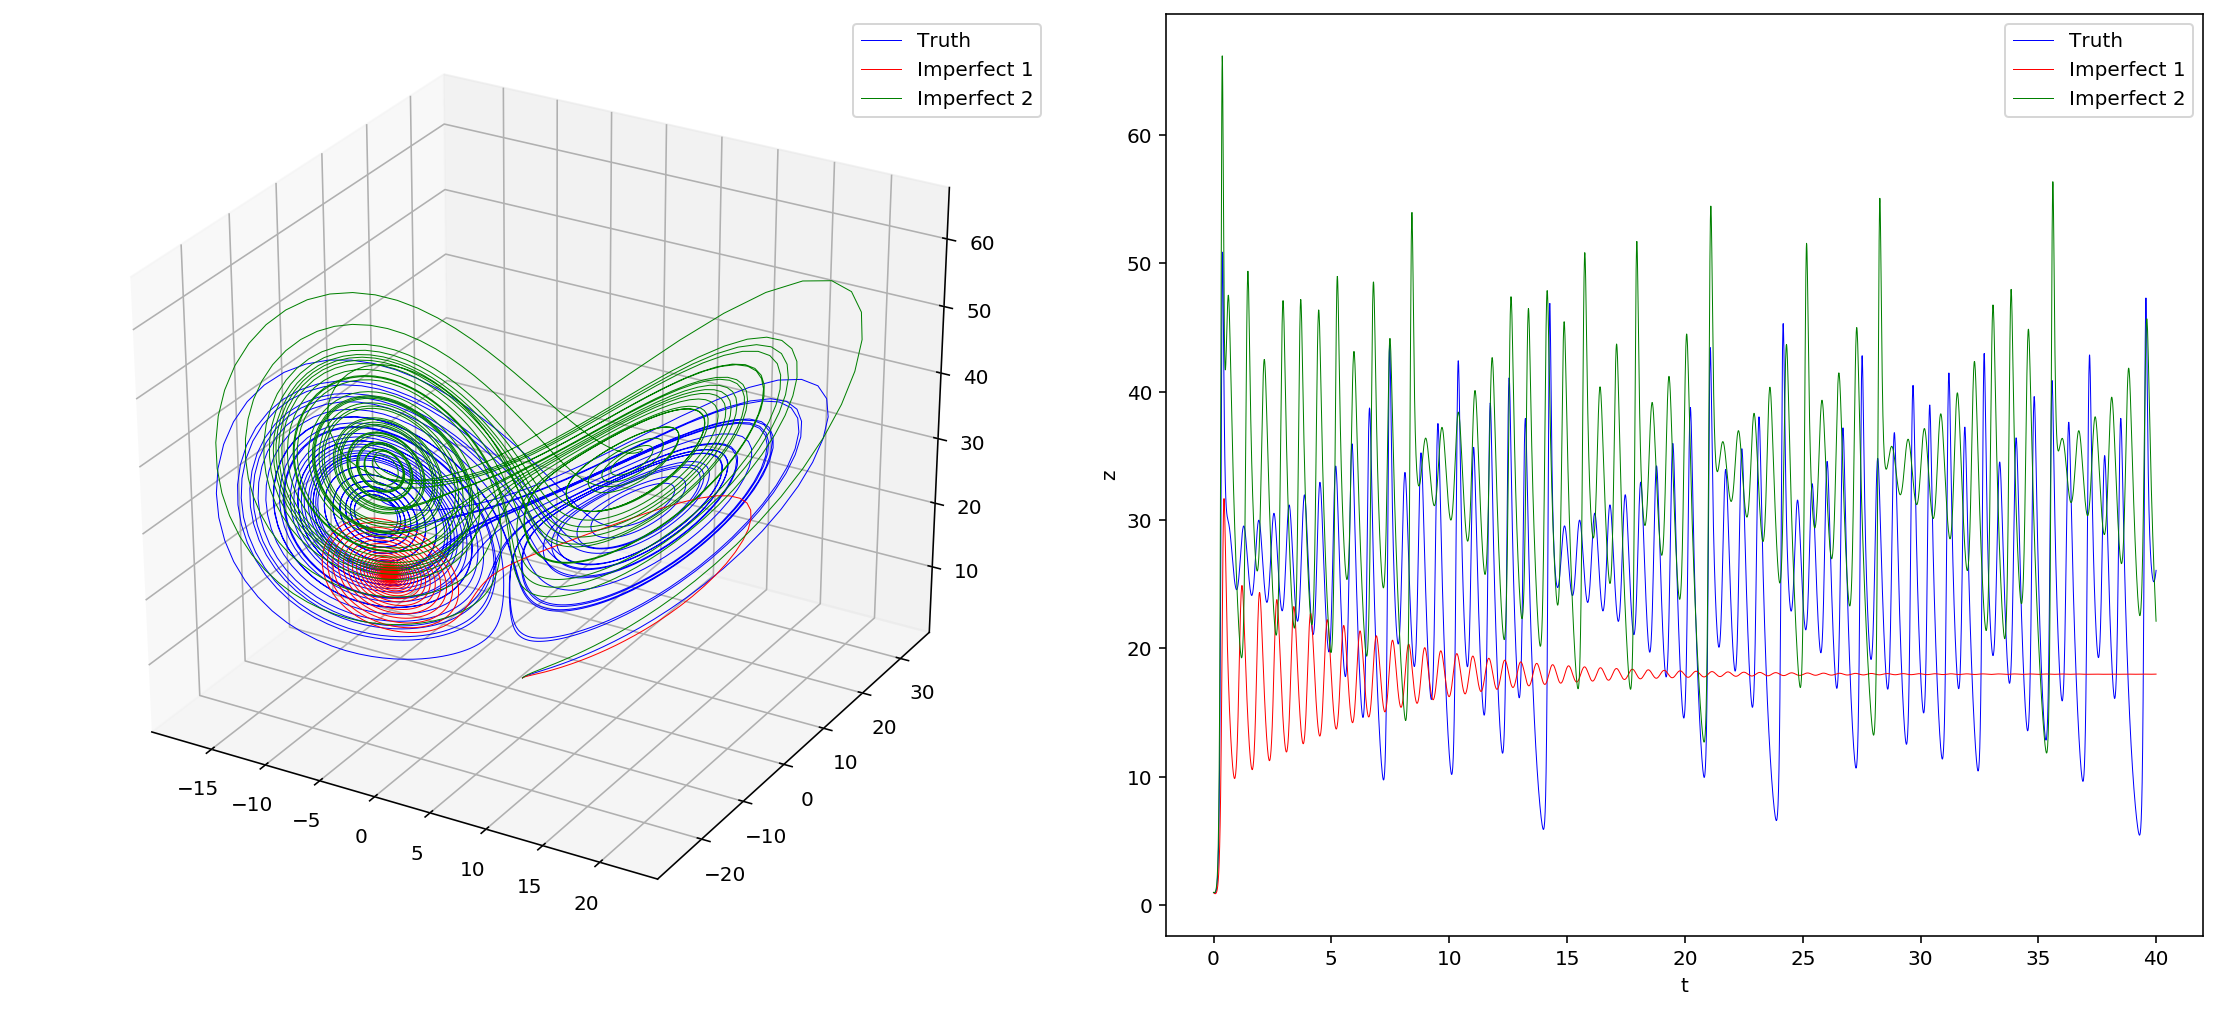

In [234]:
%matplotlib inline    
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# This return time deviation of three state variable x, y, z of the Lorenz 63 model
def Lorenz_deriv(state, params=(10.0,28.0,8.0 / 3.0)):
    x, y, z = state  # Unpack the state vector
    (sigma,rho,beta)=params
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

# Using Runge Kutta 4 to advance 1 step
def Lorenz_RK4_int(state,params,dt):
    x, y, z = state
    k1x,k1y,k1z = Lorenz_deriv([x,y,z],params)
    k2x,k2y,k2z = Lorenz_deriv([x+k1x*dt/2,y+k1z*dt/2,z+k1z*dt/2],params)
    k3x,k3y,k3z = Lorenz_deriv([x+k2x*dt/2,y+k2z*dt/2,z+k2z*dt/2],params)
    k4x,k4y,k4z = Lorenz_deriv([x+k3x*dt,y+k3z*dt,z+k3z*dt],params)
    x = x + dt*(k1x+2*k2x+2*k3x+k4x)/6
    y = y + dt*(k1y+2*k2y+2*k3y+k4y)/6
    z = z + dt*(k1z+2*k2z+2*k3z+k4z)/6    
    return [x,y,z]

# Using euler to advance 1 step
def Lorenz_int(state,params,dt):
    x, y, z = state
    k1x,k1y,k1z = Lorenz_deriv([x,y,z],params)
    x = x + dt*k1x
    y = y + dt*k1y
    z = z + dt*k1z    
    return [x,y,z]


#Plot the difference between Truemodel and imperfect models    
state0 = [1.0, 1.0, 1.0]         # Initial values 
dt = 0.01
Tmax=40
t = np.arange(0.0, Tmax, dt)   # time steps for integration 
nt= len(t)


Truemodel=(10., 28., 8/3.)
Impmodel1=(12.25, 19, 3.3)
Impmodel2=(7.5, 35, 1.9)

statesT=np.empty([nt,3])
states1=np.empty([nt,3])
states2=np.empty([nt,3])
statesT[0,:]=state0
states1[0,:]=state0
states2[0,:]=state0
for i in range(nt-1):
    statesT[i+1,:]=Lorenz_RK4_int(statesT[i,:], Truemodel, dt)
    states1[i+1,:]=Lorenz_RK4_int(states1[i,:], Impmodel1, dt)
    states2[i+1,:]=Lorenz_RK4_int(states2[i,:], Impmodel2, dt)
    

fig = plt.figure(figsize=(16, 8))
left, bottom, width, height = 0.05, 0.1, 0.45, 0.8
ax1 = fig.add_axes((left, bottom, width, height),projection='3d')
ax2 = fig.add_axes((2*left+width, bottom, width, height))
ax1.plot(statesT[:, 0], statesT[:, 1], statesT[:, 2],c="b",linewidth=0.5,label="Truth")
ax1.plot(states1[:, 0], states1[:, 1], states1[:, 2],c="r",linewidth=0.5,label="Imperfect 1")
ax1.plot(states2[:, 0], states2[:, 1], states2[:, 2],c="g",linewidth=0.5,label="Imperfect 2")
ax1.legend()

ax2.plot(t,statesT[:, 2],c="b",linewidth=0.5,label="Truth")
ax2.plot(t,states1[:, 2],c="r",linewidth=0.5,label="Imperfect 1")
ax2.plot(t,states2[:, 2],c="g",linewidth=0.5,label="Imperfect 2")
ax2.legend()
ax2.set_ylabel("z")
ax2.set_xlabel("t")
plt.show()


### 3.1 Training the supermodel

Training timesteps: 200
First guess weights:
 [[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
iteration:199-->Trained Weights:
 [[0.53661862 0.42873139 0.51724495]
 [0.46338138 0.57005442 0.48275505]]


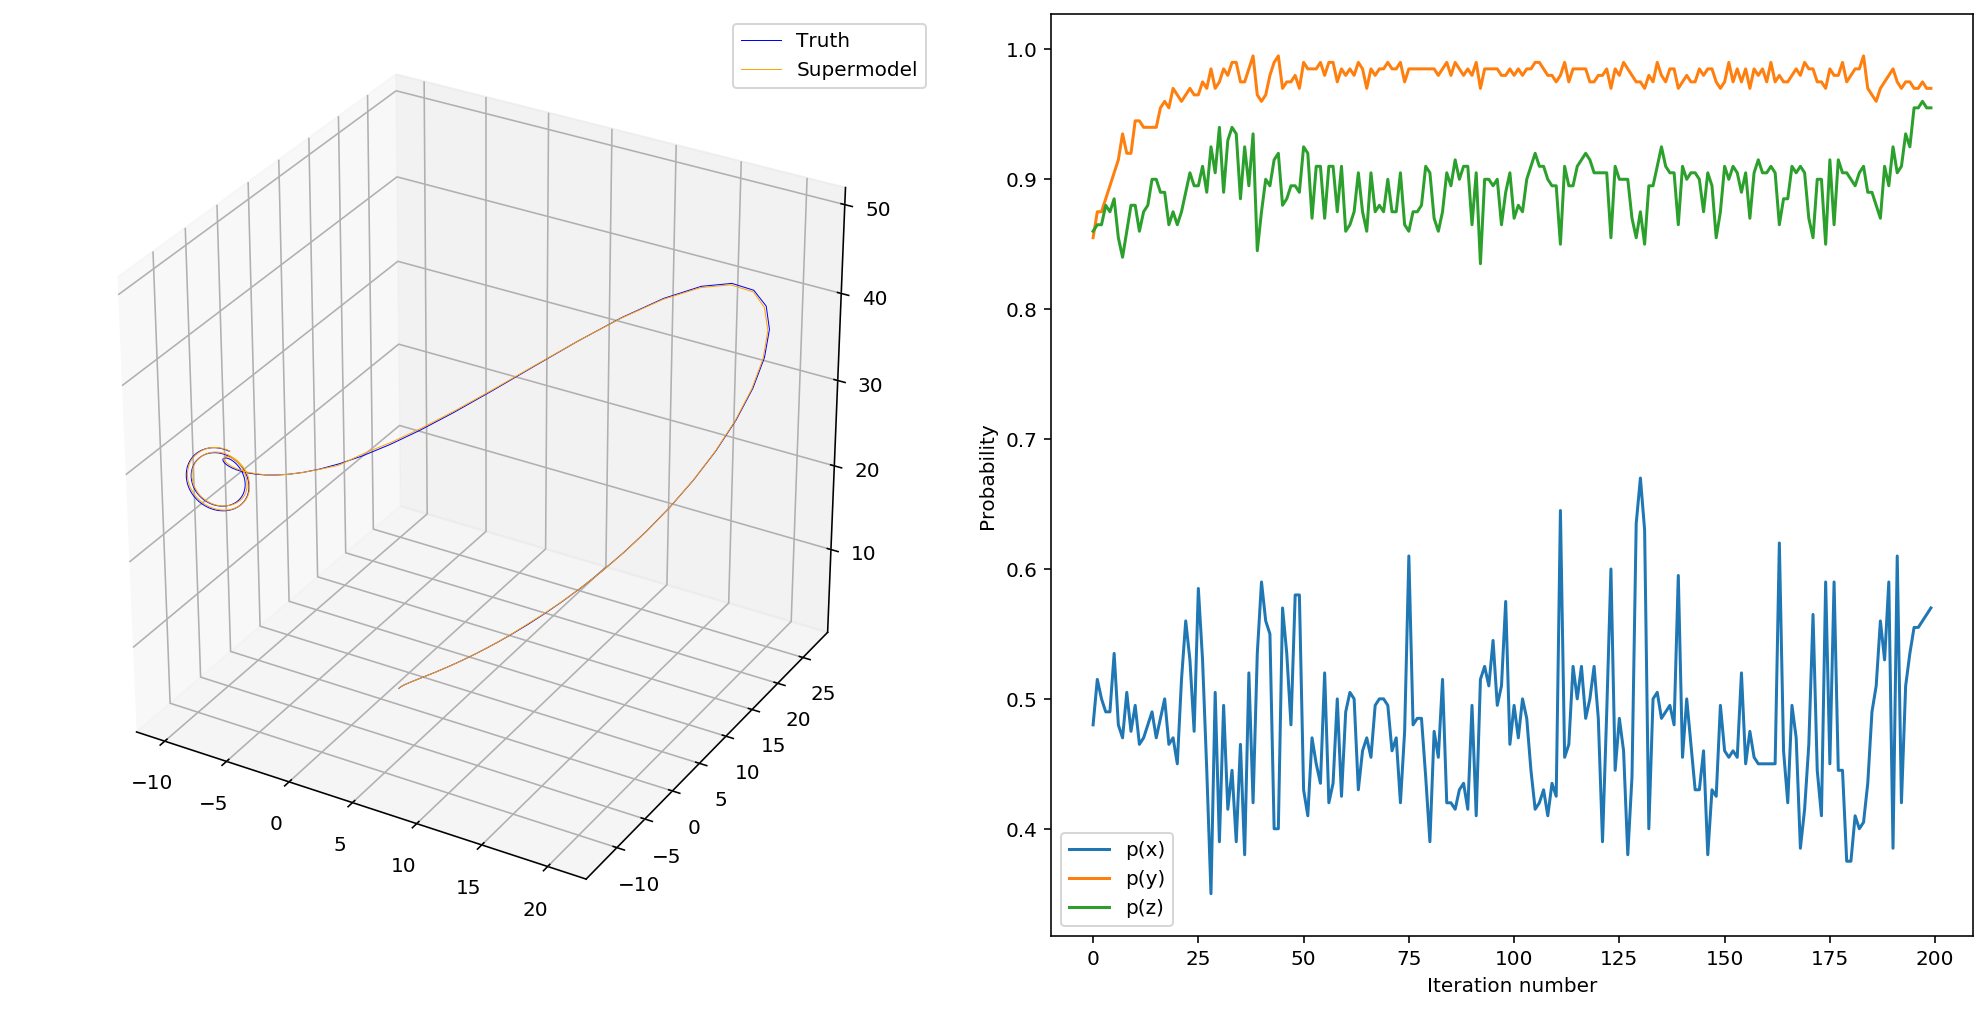

In [237]:
from sys import stdout

tMax=2
dt = 0.01
t = np.arange(0.0, tMax, dt)   # time steps for integration 
nt= len(t)
print("Training timesteps:",nt)
Max_interations=200
Learning_rate=0.1

#Measure the convergence by the winning freq of the supermodels: Swin
#Absolute convergence reached if Swin=1
Pwin=np.zeros([Max_interations,3])


# First guess weights
weights = np.zeros([2,3],dtype=np.float)
weights[:,:]=0.5

#weights=np.array([[0.5248,0.4385,0.5491],
#          [0.4752,0.5615,0.4509]])
#weights=np.array([[0.8,0.8,0.8],
#          [0.2,0.2,0.2]])
print("First guess weights:\n",weights)


for itt in range(Max_interations):
    stdout.write("\riteration:%d"%itt)
    state0 = [1.0, 1.0, 1.0]         # Initial values 
    statesT=np.empty([nt,3])
    statesS=np.empty([nt,3])
    states1=np.empty([nt,3])
    states2=np.empty([nt,3])
    statesS[0,:]=state0
    statesT[0,:]=state0
    states1[0,:]=state0
    states2[0,:]=state0
    stateT=state0
    state1=state0
    state2=state0
    winning_count=np.zeros([3,3],dtype=np.integer) # count of winning for each models/each states variables
    for it in range(nt-1):
        # New prediction at at the next time step   
        stateT=Lorenz_RK4_int(stateT, Truemodel, dt)
        state1=Lorenz_RK4_int(state0, Impmodel1, dt)
        state2=Lorenz_RK4_int(state0, Impmodel2, dt)        
        stateS = np.sum(weights*np.vstack((state1,state2)),axis=0)

        statesT[it+1,:]=stateT
        statesS[it+1,:]=stateS
        states1[it+1,:]=state1
        states2[it+1,:]=state2
        
        # Find the winner for each state variable
        states_predict=np.vstack((state1,state2,stateS))   
        diff=np.abs(states_predict - stateT)    # Absolute error, using numpy broadcasting rule
        winid=np.argmin(diff,axis=0) 
        #print("Predict:\n",states_predict)
        #print("True:\n",stateT)
        for i in (0,1,2):
            winning_count[winid[i],i] += 1
            state0[i]=states_predict[winid[i],i]
        #print("windid",winid)
        #print("-->",state0)
        #print(winning_count)

        #stdout.write("\r %d "%it)
        statenew=stateT
        
    #print(winning_count)        
    # Now caculate the winning frequencies
    freqs=winning_count/nt
    Pwin[itt,:]=freqs[2,:] 
    #print("-->\Freqs:\n",freqs)
    #print("-->f_s:\n",freqs[2,:])
    # And udpate the new weight, f_s=freqs[2,:]
    
    #We can do like this
    #prob = freqs[0:2,:]/np.sum(freqs[0:2,:],axis=0)
    #However, let's loop to check if the sum of frequencies=0
    for i in (0,1,2):  # 3 state variables
        prob=0
        sum_freq=np.sum(freqs[0:2,i])
        if (sum_freq>0):
            prob=freqs[0:2,i]/sum_freq
        #weights[0:2,i] = freqs[2,i]*weights[0:2,i] + (1-freqs[2,i])*prob
        weights[0:2,i] = (1-Learning_rate+Learning_rate*freqs[2,i])*weights[0:2,i] + Learning_rate*(1-freqs[2,i])*prob
    #print("-->Weights:\n",weights)
    
print("-->Trained Weights:\n",weights)




fig = plt.figure(figsize=(16, 8))
left, bottom, width, height = 0.05, 0.1, 0.4, 0.8
ax1 = fig.add_axes((left, bottom, width, height),projection='3d')
ax2 = fig.add_axes((2*left+width, bottom, width, height))

ax1.plot(statesT[:, 0], statesT[:, 1], statesT[:, 2],"-",c="b",linewidth=0.5,label="Truth")
ax1.plot(statesS[:, 0], statesS[:, 1], statesS[:, 2],"-",c="orange",linewidth=0.5,label="Supermodel")
ax1.legend()

ax2.plot(Pwin[:,0],linewidth=1.5,label="p(x)")
ax2.plot(Pwin[:,1],linewidth=1.5,label="p(y)")
ax2.plot(Pwin[:,2],linewidth=1.5,label="p(z)")
ax2.legend()
ax2.set_ylabel("Probability")
ax2.set_xlabel("Iteration number")
plt.show()




### 3.2 Running The Supermodels 

Trained weights:
 [[0.53661862 0.42873139 0.51724495]
 [0.46338138 0.57005442 0.48275505]]
SS17's weights:
 [[0.5248 0.4385 0.5491]
 [0.4752 0.5615 0.4509]]


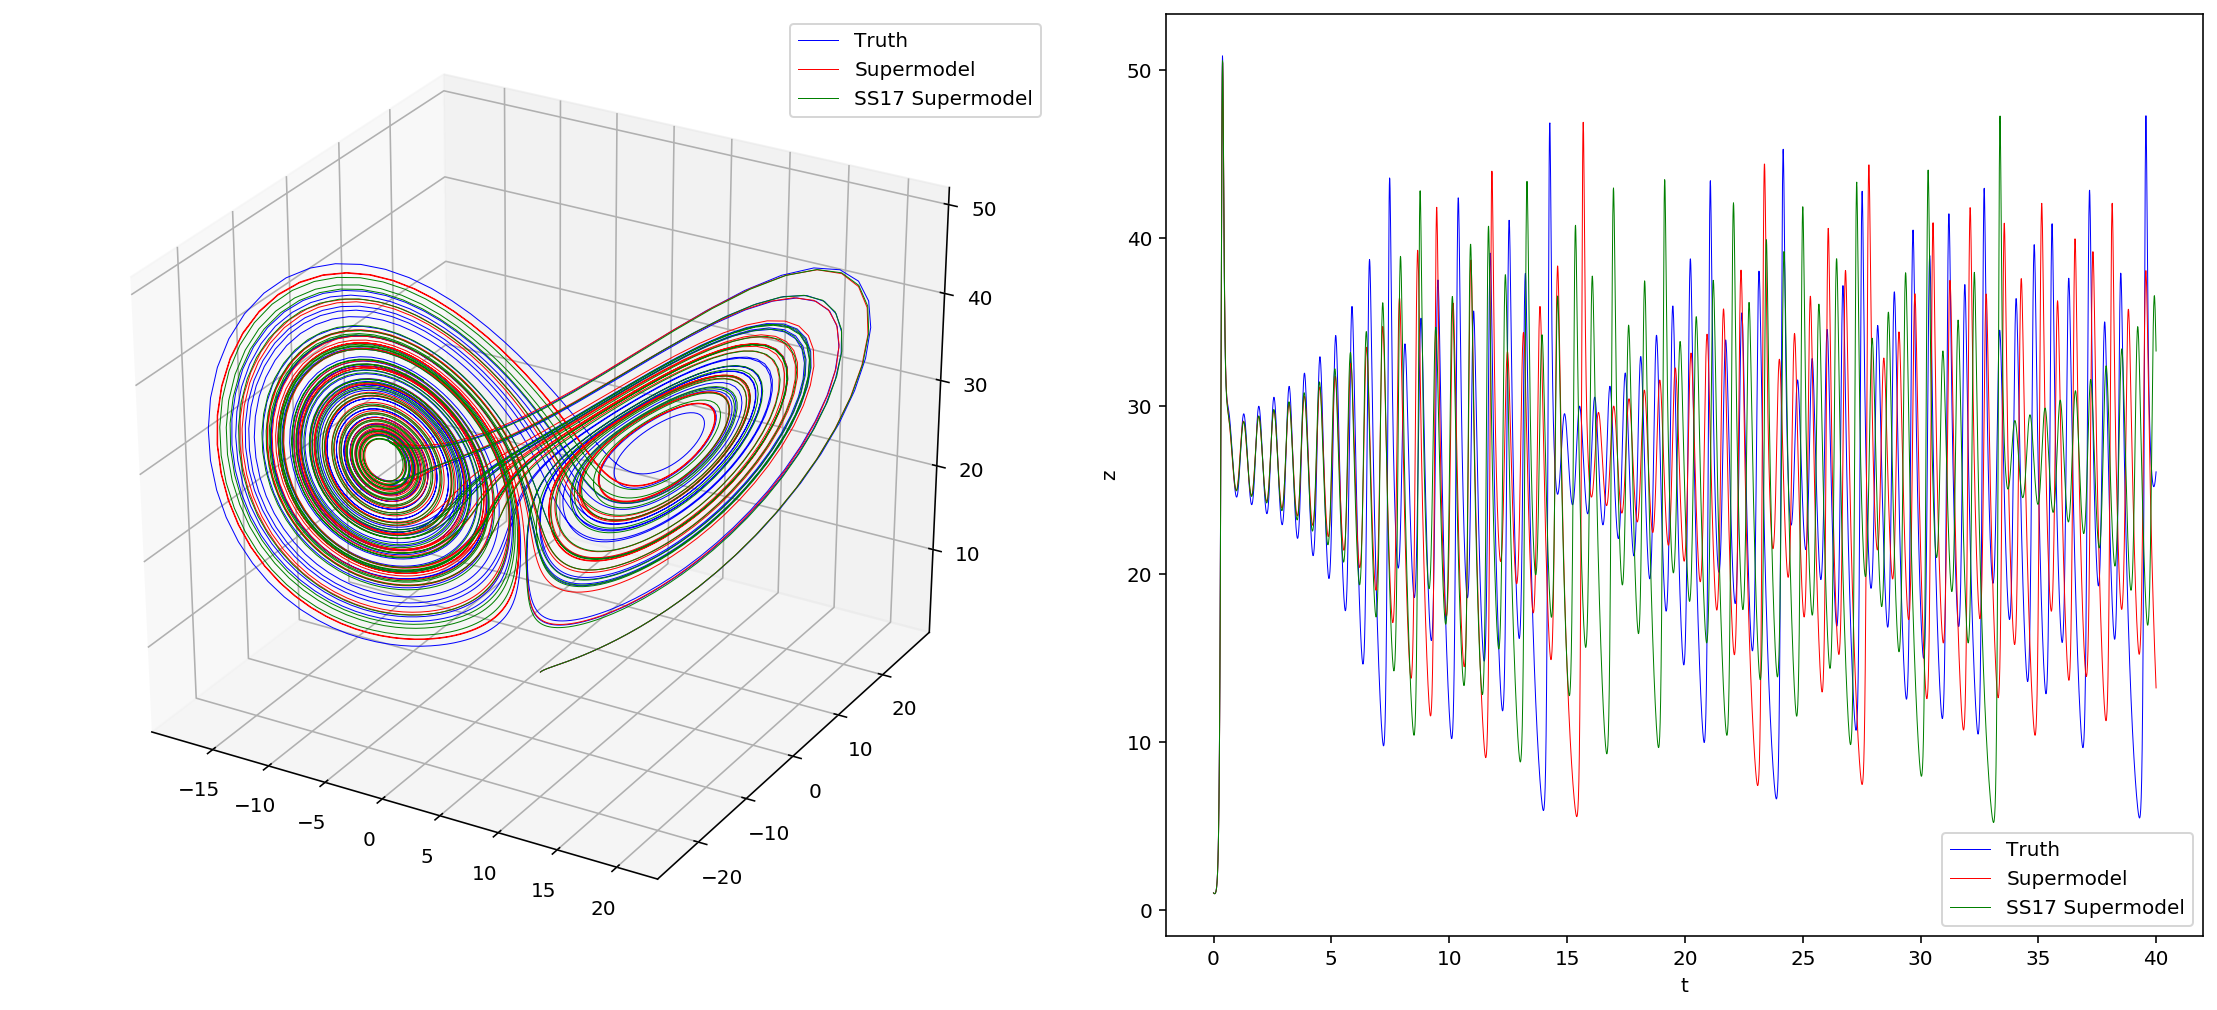

In [236]:
tMax=40
dt = 0.01
t = np.arange(0.0, tMax, dt)   # time steps for integration 
nt= len(t)
Max_interations=100
Learning_rate=1


weights_SS=np.array([[0.5248,0.4385,0.5491],
          [0.4752,0.5615,0.4509]])

print("Trained weights:\n",weights)
print("SS17's weights:\n",weights_SS)


state0 = [1.0, 1.0, 1.0]         # Initial values 
state0_SS = [1.0, 1.0, 1.0] 
statesT=np.empty([nt,3])
statesS=np.empty([nt,3])
statesS_SS=np.empty([nt,3])
statesS[0,:]=state0
statesS_SS[0,:]=state0
statesT[0,:]=state0
stateT=state0
for it in range(nt-1):
    # New prediction at at the next time step   
    stateT=Lorenz_RK4_int(stateT, Truemodel, dt)
    statesT[it+1,:]=stateT
    
    state1=Lorenz_RK4_int(state0, Impmodel1, dt)
    state2=Lorenz_RK4_int(state0, Impmodel2, dt)        
    stateS = np.sum(weights*np.vstack((state1,state2)),axis=0)
    statesS[it+1,:]=stateS
    state0=stateS
    
    state1=Lorenz_RK4_int(state0_SS, Impmodel1, dt)
    state2=Lorenz_RK4_int(state0_SS, Impmodel2, dt)        
    stateS_SS = np.sum(SSweights*np.vstack((state1,state2)),axis=0)
    statesS_SS[it+1,:]=stateS_SS
    state0_SS=stateS_SS

    



fig = plt.figure(figsize=(16, 8))
left, bottom, width, height = 0.05, 0.1, 0.45, 0.8
ax1 = fig.add_axes((left, bottom, width, height),projection='3d')
ax2 = fig.add_axes((2*left+width, bottom, width, height))
ax1.plot(statesT[:, 0], statesT[:, 1], statesT[:, 2],c="b",linewidth=0.5,label="Truth")
ax1.plot(statesS[:, 0], statesS[:, 1], statesS[:, 2],c="r",linewidth=0.5,label="Supermodel")
ax1.plot(statesSS[:, 0], statesSS[:, 1], statesSS[:, 2],c="g",linewidth=0.5,label="SS17 Supermodel")
ax1.legend()

ax2.plot(t,statesT[:, 2],c="b",linewidth=0.5,label="Truth")
ax2.plot(t,statesS[:, 2],c="r",linewidth=0.5,label="Supermodel")
ax2.plot(t,statesSS[:, 2],c="g",linewidth=0.5,label="SS17 Supermodel")
ax2.legend()
ax2.set_ylabel("z")
ax2.set_xlabel("t")
plt.show()

## 4. Discussion

I could not reproduce the exact trained weight as in Schevenhoven and Selten (2017). They did not described explicitly the method of caculuating weights in interative steps, so the actual training algorithm may be different. 

Schevenhoven and Selten (2017) described the convergence of the super model in the training process. Which imply the probality of the winning prediction of the supermodel should converge to 1. However, they did not show such diagram.

In this case, the probality of the winning prediction shows a chaotic nature, the winning probability for X is lowest and never converge to a specific value. 



## Reference
Schevenhoven, F. J., & Selten, F. (2017): An efficient training scheme for supermodels. *Earth Syst. Dynam.*, **8**, 429–438.
